# CAR ACCIDENTS IN SWITZERLAND

## The Pizzafels

### Notebook for milestone 3

### .Imports

In [87]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import math
import numpy as np

%pylab inline
pylab.rcParams['figure.figsize'] = (20,12)

Populating the interactive namespace from numpy and matplotlib


### .Constants

In [4]:
DATA_FOLDER = 'data_clean'
IS_DATE = re.compile("^[1-2]{1}[0-9]{3}$") #will be useful to detect values that correspond to dates

### .Usefull functions

#### Function to quickly describe a dataframe

In [5]:
def describeDf(df,name="DESCRIPTION",level=2):
    """
    Describe the data. Different levels are possible.
    Level 0: Print the title of the dataset
    Level 1: Name the different columns
    Level 2: Explore the values of each column
    """
    date=[]
    if(level==2):
        # Print a header
        print("______________________________ " + name+" ______________________________\n")
        print("\n")
        for col in df.columns:
            # Print the attributes of each column
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                print("         ATTRIBUTE: "+col)
                print("   "+str(df[col].unique()))
                print("\n")
            else:
                date.append(col)
        # Print the years we have information on
        print("         VALUES: "+str(date))
        print("\n\n\n")
        return
    elif(level==1):
        # Print a header
        print("______________________________ " + name+" ______________________________\n")
        val = []
        # Print the different columns
        for col in df.columns:
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                val.append(col)
        print(val)
        print("\n\n\n")
        return
    elif(level==0):
        print("   >  " + name+"\n")
    else:
        raise NotImplementedError

#### Function to restrict the dataframe to a fix period in term of years

In [6]:
def get_period(df, start=None,end=None):
    columns_to_keep = []
    dates = []
    for elem in df.columns:
        if not IS_DATE.match(elem):
            columns_to_keep.append(elem)
        else:
            dates.append(int(elem))
    if start == None:
        start = np.min(dates)
    if end == None:
        end = np.max(dates)
    
    for date in dates:
        if (date<=end) & (date>=start):
            columns_to_keep.append(str(date))
    
    return df[columns_to_keep]

#### Function to get the age corresponding to the intervales as input

In [7]:
def build_age(intervales,age_max):
    ages_total = []
    for i in range(len(intervales)-1):
        ages = []
        ages.append(intervales[i])
        for k in range(int(intervales[i]),int(intervales[i+1])):
            age = map_int_to_age(k,age_max)
            ages.append(age)
            if(k==100):
                break
        ages_total.append(ages)
    return ages_total

In [8]:
def map_int_to_age(k,age_max):
    if(k != 1 and k<age_max):
        return '{} ans'.format(k)
    if(k == 1):
        return '{} an'.format(k)
    if(k==age_max):
        if (age_max == 100):
            return '{} ans ou plus'.format(age_max)
        else:
            return '{} ans et plus'.format(age_max)

#### Mapping for cantons

In [77]:
dict_cantons = dict()
dict_cantons['AA'] = ['Appenzell Rh.-Ext.','Appenzell Ausserrhoden']
dict_cantons['AG'] = ['Argovie','Aargau']
dict_cantons['AI'] = ['Appenzell Rh.-Int.','Appenzell Innerrhoden']
dict_cantons['BE'] = ['Berne', 'Bern', 'Bern / Berne']
dict_cantons['BL'] = ['Bâle-Campagne','Basel-Landschaft']
dict_cantons['BS'] = ['Bâle-Ville','Basel-Stadt']
dict_cantons['FR'] = ['Fribourg', 'Fribourg / Freiburg']
dict_cantons['GE'] = ['Genève', 'Genf']
dict_cantons['GL'] = ['Glaris', 'Glarus']
dict_cantons['GR'] = ['Grisons', 'Graubünden', 'Grigioni', 'Grischun', 'Graubünden / Grigioni / Grischun']
dict_cantons['JU'] = ['Jura']
dict_cantons['LU'] = ['Lucerne', 'Luzern']
dict_cantons['NE'] = ['Neuchâtel']
dict_cantons['NW'] = ['Nidwald', 'Nidwalden']
dict_cantons['OW'] = ['Obwald', 'Obwalden']
dict_cantons['SG'] = ['St. Gall', 'St. Gallen','Saint-Gall']
dict_cantons['SH'] = ['Schaffhouse', 'Schaffhausen']
dict_cantons['SO'] = ['Soleure', 'Solothurn']
dict_cantons['SZ'] = ['Schwytz', 'Schwyz']
dict_cantons['TE'] = ['Tessin', 'Ticino']
dict_cantons['TG'] = ['Thurgovie', 'Thurgau']
dict_cantons['UR'] = ['Uri']
dict_cantons['VS'] = ['Valais', 'Wallis', 'Valais / Wallis']
dict_cantons['VD'] = ['Vaud']
dict_cantons['ZG'] = ['Zoug', 'Zug']
dict_cantons['ZH'] = ['Zurich', 'Zürich']

def getKeysByValue(dictOfElements, valueToFind):
    '''
    find the key of a canton
    '''
    for item  in dictOfElements.items():
        if valueToFind in item[1]:
            return item[0]
            break
    raise NotImplementedError

### .Datasets Loading

We took many datasets from the website OpenSwissData. All these datasets are excels spreedsheet in differents forms so we did a pre-treatment to transform all the datasets into a clear csv. All these csv files are store in the folder `data_clean`.

The pre-treatment was huge since the datasets were sometimes split into multiple spreedsheets (on for each year) for example. Moreover, the excel files were organized to be visually good looking, with many merged cells and various hierachical levels in the data, thus requiring more work to clean and ready it for the future processings with pandas. 

#### Snapshot of our different datasets

In [9]:
dataframes = {}
print("  DATAFRAMES AVAILABLES:\n")

for file in os.listdir(DATA_FOLDER):
    # Load the filename
    filename = os.fsdecode(file)
    # Name the corresponding DataFrame "df_....."
    tablename = "df_"+os.path.splitext(os.path.splitext(filename)[0])[0]
    # Load the values in the DataFrame
    globals()[tablename] = pd.read_csv(DATA_FOLDER + '/' + filename)
    try:
        globals()[tablename] = globals()[tablename].drop(columns=['Unnamed: 0'])
    except:
        pass
    # Print the title of the datasets
    describeDf(globals()[tablename], name=tablename,level=0)
    dataframes[tablename] = globals()[tablename]
    
    

  DATAFRAMES AVAILABLES:

   >  df_Accident_cantons

   >  df_Accident_circonstances

   >  df_Accident_objets

   >  df_Accident_type_route

   >  df_Accident_victimes

   >  df_Besoin_sante

   >  df_Depense_menages_canton

   >  df_Frais_routes_cantonales

   >  df_Frais_routes_communales

   >  df_Frais_routes_nationales

   >  df_hacked_accident

   >  df_Longueur_routes

   >  df_Population_2010

   >  df_Population_age_1992

   >  df_Population_canton_1992

   >  df_Proportion_permis

   >  df_Qualite_vie_agglo

   >  df_Recettes_routes

   >  df_Voitures



# ANALYSIS

## 1. Accidents in Switzerland: A description

### 1.1. Who?

#### 1.1.1. Sexe and age in population

In [49]:
# Get the total swiss population
ages = build_age(df_Accident_objets.age_index.unique(),100)
df_Population_2010_trancheAge = df_Population_2010.copy()
for age in ages:
    df_Population_2010_trancheAge[str(age[0])] = df_Population_2010_trancheAge.loc[:,age[1:]].sum(axis=1)

toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
toKeep.append('annee')
toKeep.append('sexe')

df_pop_Suisse = df_Population_2010_trancheAge[(df_Population_2010_trancheAge['canton'] == 'Suisse')\
                                              & (df_Population_2010_trancheAge['sexe'] != 'Sexe - Total')\
                                     & (df_Population_2010_trancheAge.etat_civil == "Etat civil - Total")]

df_pop_Suisse = df_pop_Suisse[toKeep]
df_pop_Suisse['annee'] = df_pop_Suisse['annee'].map(int).map(str)
df_pop_Suisse = df_pop_Suisse.groupby(['annee','sexe']).sum()
df_pop_Suisse = df_pop_Suisse.transpose()
df_pop_Suisse.index = df_pop_Suisse.index.map(float)

df_Suisse_1992 = df_Population_age_1992[(df_Population_age_1992.sexe != 'Sexe - Total') & (df_Population_age_1992.age != 'Age - Total')]
df_Suisse_1992 = df_Suisse_1992.groupby(['age','sexe']).sum().transpose()
ages = build_age(df_Accident_objets.age_index.unique(),99)
for age in ages:
    for s in df_Population_age_1992[df_Population_age_1992.sexe != 'Sexe - Total'].sexe.unique():
        index_to = [(annee,s) for annee in age[1:]]
        df_Suisse_1992[(str(age[0]),s)] = df_Suisse_1992.loc[:,index_to].sum(axis=1)
df_Suisse_1992 = df_Suisse_1992.transpose().reset_index().set_index('age').transpose()

toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
df_Suisse_1992 = df_Suisse_1992[toKeep]
df_Suisse_1992 = df_Suisse_1992.transpose()

for year in range(1992,2010):
    for sexe in np.unique([sexe[1] for sexe in df_pop_Suisse.columns.values]):
        df_pop_Suisse[(str(year),sexe)] = df_Suisse_1992.loc[df_Suisse_1992.sexe==sexe][str(year)]

C:\Users\Clementg20\Anaconda3\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


In [50]:
df_Accident_objets_normalized = df_Accident_objets.copy()
df_Accident_objets_normalized = df_Accident_objets_normalized[df_Accident_objets_normalized['sexe_index']!=9]
for year,sexe in df_pop_Suisse.columns.values:
    for age in df_pop_Suisse.index.values:
        df_Accident_objets_normalized.loc[(df_Accident_objets_normalized.age_index==age) &\
                                           (df_Accident_objets_normalized.sexe==sexe),year]\
        = df_Accident_objets_normalized[year]*10000 / df_pop_Suisse.loc[df_pop_Suisse.index==age,year][sexe].values[0]

df_Accident_objets_normalized = df_Accident_objets_normalized[df_Accident_objets_normalized.age_index != 999]

In [51]:
df_conducteur = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized.voiture_index==210)]
df_conducteur = df_conducteur.groupby(['sexe','age']).sum().sort_values(['2017'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
print("Number of accident for different sexe and age for 1/10.000 inhabitants in Swiss")
display(df_conducteur.head(5))

Number of accident for different sexe and age for 1/10.000 inhabitants in Swiss


1992        1993        1994        1995       1996  \
sexe  age                                                                    
Homme 20 ans     127.971524  117.852950  125.859697  115.426207  92.977202   
      18-19 ans   91.262445   85.548212   79.800978   79.263615  84.056135   
      21-29 ans   79.562532   75.568450   75.104204   74.622609  67.304099   
Femme 20 ans      41.204299   47.217153   39.882947   42.637725  36.786490   
Homme 30-39 ans   43.852580   41.868027   41.974276   41.392829  39.754567   

                       1997        1998        1999        2000        2001  \
sexe  age                                                                     
Homme 20 ans     111.426699  117.792183  130.883766  118.059614  131.882700   
      18-19 ans   78.972986   86.307553   87.905889   97.575091   99.309354   
      21-29 ans   67.516639   73.536188   76.999389   74.377638   72.578555   
Femme 20 ans      33.910984   38.310314   41.470970   47.580900   48.580501   
Homme 30-39 ans   40.106226   39.883317   44.419721   41.375975   42.328752   

                   ...           2008       2009       2010       2011  \
sexe  age          ...                                                   
Homme 20 ans       ...      76.846329  68.903970  60.461671  61.102625   
      18-19 ans    ...      68.300948  65.115308  55.686596  59.962381   
      21-29 ans    ...      50.191485  48.996512  42.968643  39.242457   
Femme 20 ans       ...      33.497884  37.035442  32.691987  24.248202   
Homme 30-39 ans    ...      28.826623  28.567289  27.008356  24.289025   

                      2012       2013       2014       2015       2016  \
sexe  age                                                                
Homme 20 ans     55.482377  45.599542  47.268263  40.245925  43.554182   
      18-19 ans  49.946674  47.051076  43.540140  37.905391  37.816045   
      21-29 ans  35.122254  33.921480  31.927447  29.644892  30.092583   
Femme 20 ans     27.287386  26.002259  31.368168  26.294974  25.347733   
Homme 30-39 ans  23.592174  23.070797  22.080219  19.292668  20.161949   

                      2017  
sexe  age                   
Homme 20 ans     39.736442  
      18-19 ans  35.445563  
      21-29 ans  28.468726  
Femme 20 ans     25.532472  
Homme 30-39 ans  21.087092  

[5 rows x 26 columns]

#### 1.1.2. Sexe in proportion of people who have the driver licence

In [27]:
# Normalization
df_conducteur_bysexe = df_Population_2010[(df_Population_2010['canton'] == 'Suisse') & (df_Population_2010['sexe'] != 'Sexe - Total')\
                                     & (df_Population_2010.etat_civil == "Etat civil - Total")]\
                .drop(columns=['canton','canton_index','permanente','etat_civil','Age - Total'])
df_conducteur_bysexe['annee'] = df_conducteur_bysexe['annee'].map(int).map(str)
df_conducteur_bysexe = df_conducteur_bysexe.groupby(['annee','sexe']).sum().transpose().sum()
df_conducteur_bysexe = pd.DataFrame(df_conducteur_bysexe)

df_conducteur_bysexe = df_conducteur_bysexe.transpose()
df_conducteur_1992 = df_Population_age_1992[(df_Population_age_1992.age == "Age - Total") & (df_Population_age_1992.sexe != 'Sexe - Total')]\
                        .drop(columns=['age'])
for year in range(1992,2010):
    for sexe in np.unique([sexe[1] for sexe in df_conducteur_bysexe.columns.values]):
        df_conducteur_bysexe[(str(year),sexe)] = df_conducteur_1992.loc[df_conducteur_1992.sexe==sexe][str(year)].values[0]
df_conducteur_bysexe = df_conducteur_bysexe.transpose().reset_index()
annee = []
for elem in df_Proportion_permis.columns:
    if IS_DATE.match(elem):
        annee.append(elem)
df_conducteur_bysexe = df_conducteur_bysexe[df_conducteur_bysexe.annee.isin(annee)].set_index(['annee','sexe']).transpose()
df_proportion_permis_sexe = df_Proportion_permis[df_Proportion_permis.critere.isin(['Hommes','Femmes'])]
for year in annee:
    for sexe in np.unique([sexe[1] for sexe in df_conducteur_bysexe.columns.values]):
        df_conducteur_bysexe[(str(year),sexe)] = int((1/100) * df_conducteur_bysexe[(str(year),sexe)].values[0] * \
                                            df_proportion_permis_sexe.loc[df_proportion_permis_sexe.critere==sexe+'s'][str(year)].values[0])
df_conducteur_bysexe.head(5)

toKeep = []
for col in df_Accident_objets.columns:
    if IS_DATE.match(col):
        if(col in annee):
            toKeep.append(col)
    else :
        toKeep.append(col)
        
df_Accident_objets_normalized_sexe = df_Accident_objets[toKeep]

for year,sexe in df_conducteur_bysexe.columns.values:
        df_Accident_objets_normalized_sexe.loc[(df_Accident_objets_normalized_sexe.sexe==sexe),year]\
        = df_Accident_objets_normalized_sexe[df_Accident_objets_normalized_sexe.sexe==sexe][year]*10000 / df_conducteur_bysexe.transpose().loc[(year,sexe)].values[0]



C:\Users\Clementg20\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
# Selection
df_conducteur = df_Accident_objets_normalized_sexe[(df_Accident_objets_normalized_sexe.faute_index==1)\
                                           & (df_Accident_objets_normalized_sexe.voiture_index==210)\
                                            & (df_Accident_objets_normalized_sexe.sexe_index <= 2)].dropna()

display(df_conducteur.groupby(['sexe']).sum()[[col for col in df_conducteur.columns if IS_DATE.match(col)]])

,1994,2000,2005,2010,2015
sexe,,,,,
Femme,20.242166,20.145474,17.871494,15.826832,13.012214
Homme,40.706444,38.940733,31.203809,25.843560,19.627099


#### 1.1.3. Âge in proportion of people who have the driver licence

In [47]:
# Normalization
map_age_permis = {}
map_age_permis['18-24 ans'] = [map_int_to_age(k,100) for k in range(18,25)]
map_age_permis['25-64 ans'] = [map_int_to_age(k,100) for k in range(25,65)]
map_age_permis['65 ans et plus'] =  [map_int_to_age(k,99) for k in range(65,100)]

df_conducteur_byage = df_Population_2010[(df_Population_2010['canton'] == 'Suisse') & (df_Population_2010['sexe'] == 'Sexe - Total')\
                                     & (df_Population_2010.etat_civil == "Etat civil - Total")\
                                       & (df_Population_2010.permanente=='Population résidante permanente')]\
                .drop(columns=['canton','canton_index','permanente','etat_civil','Age - Total'])
df_conducteur_byage['annee'] = df_conducteur_byage['annee'].map(int).map(str)
df_conducteur_byage = df_conducteur_byage.groupby(['annee']).sum()
df_conducteur_byage = df_conducteur_byage.transpose()[[col for col in df_Proportion_permis.columns if ((col!='critere') and (int(col)>=2010)) ]].transpose()
df_conducteur_byage['99 ans et plus'] = df_conducteur_byage['99 ans'] +  df_conducteur_byage['100 ans ou plus']
df_conducteur_byage = df_conducteur_byage.drop(['99 ans','100 ans ou plus'],axis=1)
df_conducteur_1992 = df_Population_age_1992[(df_Population_age_1992.age != "Age - Total") & (df_Population_age_1992.sexe == 'Sexe - Total')]\
                        .drop(columns=['sexe']).set_index('age')
df_conducteur_1992 = df_conducteur_1992[[col for col in df_Proportion_permis.columns if ((col!='critere') and (int(col)<=2010)) ]].transpose()

df_conducteur_byage = df_conducteur_byage.transpose()
df_conducteur_1992 = df_conducteur_1992.transpose()
for col in df_conducteur_1992.columns:
    df_conducteur_byage[col] = df_conducteur_1992[col]
df_conducteur_byage = df_conducteur_byage.transpose()
df_conducteur_byage = df_conducteur_byage.sort_values(['annee'])
toKeep = []
for elem in map_age_permis:
    toKeep.append(elem)
df_Proportion_permis_age = df_Proportion_permis[df_Proportion_permis.critere.isin(toKeep)]
df_Proportion_permis_age = df_Proportion_permis_age.set_index('critere').transpose()
toKeep = []
for elem in map_age_permis:
    for age in map_age_permis[elem]:
        toKeep.append(age)
        df_conducteur_byage[age] = df_conducteur_byage[age]*df_Proportion_permis_age[elem]/100
df_conducteur_byage = df_conducteur_byage[toKeep]

ages = [age for age in  build_age(df_Accident_objets.age_index.unique(),99) if age[0]>=18]

toKeep = []
for age in ages:
    toKeep.append(str(age[0]))
    df_conducteur_byage[str(age[0])] = df_conducteur_byage.loc[:,age[1:]].sum(axis=1)
df_conducteur_byage = df_conducteur_byage[toKeep].transpose()

df_Accident_objets_normalized_licence = df_Accident_objets.copy()
df_Accident_objets_normalized_licence = df_Accident_objets_normalized_licence[df_Accident_objets_normalized_licence['sexe_index']!=9]

toKeep = []
for col in df_Accident_objets_normalized_licence.columns:
    if IS_DATE.match(col):
        if col in df_conducteur_byage.columns:
            toKeep.append(col)
    else:
        toKeep.append(col)
df_Accident_objets_normalized_licence = df_Accident_objets_normalized_licence[toKeep]

for year in df_conducteur_byage.columns.values:
    for age in df_conducteur_byage.index.values:
        df_Accident_objets_normalized_licence.loc[(df_Accident_objets_normalized_licence.age_index==int(float(age))),year]\
        = df_Accident_objets_normalized_licence.loc[(df_Accident_objets_normalized_licence.age_index==int(float(age))),year]*10000 / df_conducteur_byage[df_conducteur_byage.index == age][year].values[0]

df_Accident_objets_normalized_licence = df_Accident_objets_normalized_licence[df_Accident_objets_normalized_licence.age_index != 999]
df_Accident_objets_normalized_licence = df_Accident_objets_normalized_licence[df_Accident_objets_normalized_licence.age_index>=18]

C:\Users\Clementg20\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [53]:
#Selection
df_conducteur = df_Accident_objets_normalized_licence[(df_Accident_objets_normalized_licence.faute_index==1)\
                                           & (df_Accident_objets_normalized_licence.voiture_index==210)\
                                            & (df_Accident_objets_normalized_licence.sexe_index <= 2)].dropna()

display(df_conducteur.groupby(['age']).sum()[[col for col in df_conducteur.columns if IS_DATE.match(col)]])

,1994,2000,2005,2010,2015
age,,,,,
18-19 ans,75.084724,91.334992,81.063997,66.788280,46.887490
20 ans,118.030850,121.371517,103.079634,81.773849,56.664058
21-29 ans,66.833960,66.524375,56.413677,45.337249,32.675074
30-39 ans,37.134922,36.547410,29.160171,24.102590,18.338493
40-49 ans,29.200308,29.255004,24.769514,21.605008,17.264957
50-59 ans,26.064044,25.630524,22.232694,19.235849,16.057786
60-69 ans,27.893487,26.552435,22.256496,19.443862,15.679813
70 ans et plus,30.497531,28.865348,22.076220,20.337065,18.264859


#### 1.1.2. Driver Licence

For this analysis, we will use the same dataset as above, with the same normalization technique as well.

In [13]:
mapping={}
index_permis = df_Accident_objets['annee_permis_index'].unique()
for i in range(len(index_permis)):
    if ((index_permis[i]==999) | (index_permis[i] == 16)):
        mapping[index_permis[i]] = 1
    else:
        mapping[index_permis[i]] = index_permis[i+1] - index_permis[i]


df_permis = df_Accident_objets_normalized.copy()

df_permis = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                            & (df_Accident_objets_normalized.voiture_index==210)]
df_permis = df_permis.groupby(['annee_permis','annee_permis_index']).sum().sort_values(['2017'], ascending=False)
dates = [col for col in df_permis.columns if IS_DATE.match(col)]

for i in range(len(df_permis.index)):
    df_permis.loc[df_permis.index.values[i]] = df_permis.loc[df_permis.index.values[i]] / mapping[df_permis.index.values[i][1]]
df_permis = df_permis[[col for col in df_permis.columns if IS_DATE.match(col)]].sort_values(['2017'], ascending=False)
display(df_permis)

,,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
annee_permis,annee_permis_index,,,,,,,,,,,,,,,,,,,,,
16 ans et plus,16.0,151.815273,155.474276,157.342421,159.380439,150.169228,156.710704,155.406126,160.250944,173.419291,169.993515,...,139.450852,138.376400,132.426681,124.912390,119.172723,115.470413,114.408562,112.456571,114.792466,110.276788
0 an,0.0,142.498171,123.374663,123.556406,128.246791,134.725968,128.560186,138.590490,148.358726,156.150508,158.154178,...,103.349710,107.369881,91.846562,90.650620,82.193101,73.991970,73.751087,66.297358,66.413550,65.903547
1 an,1.0,115.056000,116.987902,105.379701,103.902776,91.447060,92.487154,105.405959,114.483453,107.449483,121.968624,...,75.841032,69.190023,60.503807,59.967035,59.746205,53.247396,52.533768,43.266116,47.139497,45.323683
2 ans,2.0,60.729173,61.781844,67.446072,53.471355,37.813368,45.859604,53.980605,55.626921,53.100989,57.694021,...,42.361811,39.063616,36.455055,30.937408,28.064216,28.548895,27.969970,26.389337,26.583125,24.397839
3 ans,3.0,21.661525,19.040279,19.630811,18.491256,15.035516,15.244542,15.719053,18.181171,17.416233,17.423043,...,12.650185,12.532630,9.571983,9.519724,9.023592,8.480907,8.390982,7.787504,6.928320,7.404767
4 ans,4.0,16.808748,16.995287,17.814692,16.587894,14.531049,15.446100,13.960209,15.545263,15.618890,15.944917,...,11.495953,9.942894,9.450254,8.815974,7.130637,8.006289,6.830234,6.806711,6.956656,6.384212
5 ans,5.0,14.839586,14.184715,15.103948,15.068976,14.938097,13.351073,12.610900,13.472970,12.903001,13.612824,...,9.823842,8.726744,8.875188,7.341964,6.291182,6.063323,6.058009,5.565988,6.087784,5.788939
6-10 ans,6.0,11.842899,11.878399,11.847684,12.108916,11.072921,11.179449,11.864022,12.247240,11.829139,11.006487,...,7.497831,6.916877,6.878061,6.050665,5.474215,5.459698,5.257620,4.839923,4.767883,4.883310
11-15 ans,11.0,7.140697,7.221451,7.627808,7.237410,6.932885,6.924822,7.010395,7.381557,7.136533,7.308527,...,4.576292,4.695898,4.416956,4.137954,4.084221,3.905022,3.713235,3.447830,3.455713,3.446991


In [54]:
# Excluding young drivers (driver licence > 4 years)
df_conducteur_confirmed = df_Accident_objets_normalized_licence[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized_licence.voiture_index==210)\
                                            &(df_Accident_objets_normalized_licence.annee_permis_index>4)\
                                             &(df_Accident_objets_normalized_licence.annee_permis_index!=999)]
df_conducteur_confirmed = df_conducteur_confirmed.groupby(['age']).sum().sort_values(['2015'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
display(df_conducteur_confirmed.head(10))

C:\Users\Clementg20\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,1994,2000,2005,2010,2015
age,,,,,
70 ans et plus,29.782502,28.722450,21.944027,20.253510,18.210458
40-49 ans,27.402831,27.615947,23.460442,20.660006,16.550109
30-39 ans,32.187670,32.226022,25.492225,21.573431,16.449715
50-59 ans,25.048185,25.116445,21.752605,18.755487,15.909874
60-69 ans,27.103371,26.257642,21.977199,19.277675,15.568213
21-29 ans,31.037925,30.492246,24.001951,21.039137,14.716563
18-19 ans,2.170079,2.248778,0.000000,0.000000,0.000000
20 ans,2.794602,2.597108,0.000000,0.000000,0.000000


In [56]:
# Âge and driver licence
df_conducteur_confirmed = df_Accident_objets_normalized_licence[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized_licence.voiture_index==210)\
                                             &(df_Accident_objets_normalized_licence.annee_permis_index!=999)]
df_conducteur_confirmed = df_conducteur_confirmed.groupby(['annee_permis','age']).sum().sort_values(['2015'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
display(df_conducteur_confirmed.head(10))

C:\Users\Clementg20\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1994       2000       2005       2010  \
annee_permis   age                                                          
0 an           18-19 ans       53.817952  71.268971  63.457337  51.354772   
1 an           20 ans          49.974065  53.500426  48.476261  33.849741   
16 ans et plus 70 ans et plus  28.632238  28.031778  21.698526  20.036270   
2 ans          20 ans          36.329830  27.183064  23.246980  23.516662   
0 an           20 ans          26.795304  35.147529  29.374091  22.804036   
16 ans et plus 60-69 ans       25.331595  25.289036  21.261500  18.869762   
               50-59 ans       22.348902  23.194767  20.358061  17.527894   
               40-49 ans       22.300315  23.065409  20.066205  17.651604   
6-10 ans       21-29 ans       22.377384  21.884826  17.880241  15.530603   
1 an           18-19 ans       17.187023  16.260396  15.680932  13.357656   

                                    2015  
annee_permis   age                        
0 an           18-19 ans       36.678846  
1 an           20 ans          22.700818  
16 ans et plus 70 ans et plus  18.088058  
2 ans          20 ans          17.069608  
0 an           20 ans          15.837780  
16 ans et plus 60-69 ans       15.275263  
               50-59 ans       14.939196  
               40-49 ans       14.278880  
6-10 ans       21-29 ans       10.909627  
1 an           18-19 ans        9.937618

In [55]:
# Without driver licence
df_conducteur_illegal = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized.voiture_index==210)\
                                             &(df_Accident_objets_normalized.annee_permis_index==999)]
df_conducteur_illegal = df_conducteur_illegal.groupby(['sexe','age']).sum().sort_values(['2017'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
display(df_conducteur_illegal.head(5))

1994      2000      2005      2010      2015
sexe  age                                                        
Homme 15-17 ans  1.408392  1.867966  1.895914  1.033928  0.593331
      21-29 ans  1.103872  1.370114  1.155609  0.757157  0.393952
      18-19 ans  2.043097  1.851959  2.030113  1.640857  0.206569
      30-39 ans  0.556733  0.612855  0.637790  0.481973  0.247978
Femme 18-19 ans  0.000000  0.000000  0.000000  0.107444  0.111356

### 1.2. Where?

#### 1.2.1. Road type

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
ruralite,,,,,,,,,,,,,,,,,,,,,
En localité,14915.0,14601.0,15123.0,14635.0,13974.0,14376.0,14329.0,14819.0,15098.0,14966.0,...,13677.0,13372.0,12587.0,12397.0,11574.0,11262.0,11644.0,11742.0,11606.0,11551.0
Hors localité,6601.0,6540.0,6576.0,6378.0,5796.0,5837.0,5866.0,6299.0,6383.0,6549.0,...,5280.0,5251.0,5129.0,4908.0,4754.0,4522.0,4466.0,4412.0,4205.0,4562.0
Sur autoroute,1756.0,1711.0,1828.0,2017.0,1808.0,1862.0,2037.0,2316.0,2256.0,2381.0,...,1779.0,1883.0,1893.0,1685.0,1820.0,1689.0,1693.0,1582.0,1766.0,1686.0


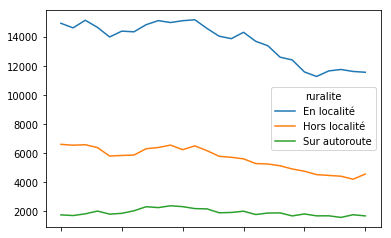

In [58]:
# Ruralite des accidents
req = df_Accident_type_route.groupby(['ruralite']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
ruralite,,,,,,,,,,,,,,,,,,,,,
Hors localité,5.862748,5.305810,4.850973,5.142678,4.951691,4.831249,4.517559,4.492777,4.778317,3.695221,...,3.409091,3.237479,3.489959,3.239609,3.007993,2.742149,2.821317,2.402539,2.544590,2.411223
Sur autoroute,4.783599,3.214494,3.118162,3.767972,3.484513,3.114930,3.436426,2.633851,1.684397,2.477950,...,1.461495,1.699416,1.162176,1.246291,1.868132,1.243339,0.708801,1.264223,0.849377,1.423488
En localité,1.857191,1.773851,1.725848,1.612573,1.517103,1.481636,1.500454,1.383359,1.404159,1.302953,...,0.950501,0.994616,0.889807,1.064774,1.071367,0.994495,0.781518,0.953841,0.740996,0.735867


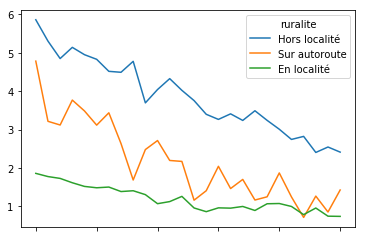

In [65]:
# Accident mortels en % des accidents sur le même type de route

total_accident = df_Accident_type_route.groupby(['ruralite']).sum()[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
df_Accident_type_route_normalized_ruralite = df_Accident_type_route.copy()
for ruralite in total_accident.index.values:
    for date in total_accident.columns:
        df_Accident_type_route_normalized_ruralite.loc[df_Accident_type_route_normalized_ruralite.ruralite==ruralite,date] =\
        df_Accident_type_route_normalized_ruralite.loc[df_Accident_type_route_normalized_ruralite.ruralite==ruralite][date]*100/\
        total_accident.loc[total_accident.index==ruralite,date][0]

req = df_Accident_type_route_normalized_ruralite[df_Accident_type_route_normalized_ruralite.gravite_index==317].groupby(['ruralite']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
temps,,,,,,,,,,,,,,,,,,,,,
Sec,70.376418,69.976370,72.308412,70.013026,70.937992,74.967157,70.830335,67.521550,71.087332,69.199866,...,72.757523,73.919828,70.069866,79.763033,72.795900,71.081097,75.650171,78.298376,74.625932,75.358166
Mouillé,19.624441,18.562927,18.871934,17.976552,16.938549,15.415629,17.177942,18.046428,18.047774,19.317041,...,15.461034,13.025456,12.932837,11.026856,14.679304,14.004464,13.806662,10.103744,13.676964,12.393955
Humide,6.540048,7.067215,6.124878,6.022579,7.243489,6.486976,7.273300,7.856107,7.882209,7.432206,...,7.667824,8.212231,8.174818,6.182201,7.515980,9.294340,8.032354,7.865359,8.613529,7.191415
Enneigé,0.898075,1.991073,1.100863,2.818063,2.354250,1.005663,2.015113,3.162072,1.171167,1.753432,...,1.885610,2.579733,4.870213,0.953133,2.430020,2.209123,0.932427,1.437754,0.927348,2.185516
Verglacé,2.045376,1.776650,1.164619,2.162397,1.825934,1.567384,2.055596,2.317146,1.301765,1.577670,...,1.610725,1.584902,2.621245,1.390205,1.361032,2.134722,0.792001,1.381371,1.098026,1.342772
Neige fondante,0.339464,0.455102,0.284779,0.885801,0.565391,0.362401,0.449802,0.951609,0.370729,0.573318,...,0.535301,0.546182,1.116834,0.442338,0.958783,0.950037,0.454979,0.603293,0.716846,1.174223
Autre état de la route,0.176177,0.170663,0.144515,0.121581,0.134396,0.194790,0.197913,0.145088,0.139023,0.146468,...,0.081983,0.131669,0.214187,0.242233,0.258982,0.326218,0.331405,0.310104,0.341355,0.353952


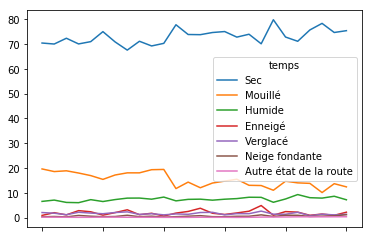

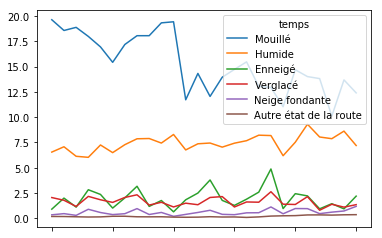

In [67]:
# Circonstance de la route des accidents par année
df_Accident_type_route_normalized = df_Accident_type_route.copy()
for date in [col for col in df_Accident_type_route_normalized.columns if IS_DATE.match(col)]:
    df_Accident_type_route_normalized[date] = df_Accident_type_route_normalized[date]*100/(df_Accident_type_route_normalized[date].sum())

req = df_Accident_type_route_normalized.groupby(['temps']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()
req = df_Accident_type_route_normalized[df_Accident_type_route_normalized.temps!='Sec'].groupby(['temps']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
vitesse,,,,,,,,,,,,,,,,,,,,,
40-50 Km/h,56.033001,55.811308,56.666808,56.204950,56.905181,56.973952,56.499640,56.144918,56.173906,55.565785,...,57.508681,56.846777,55.999796,56.566614,55.344942,55.582899,56.411841,56.365584,56.289469,55.132311
70-80 Km/h,25.786353,26.045860,25.302844,25.062961,24.520345,24.271801,24.307305,24.383375,24.543961,24.514563,...,21.677276,22.232517,22.357081,22.111638,22.531408,21.873748,21.558164,21.075778,20.219605,21.051744
60 Km/h,11.528876,11.491336,11.250903,11.016066,11.238298,11.084938,10.979669,10.433558,10.544719,10.763308,...,10.300926,9.923925,9.985211,10.021064,9.962530,9.820866,9.195079,9.539919,9.392957,9.961234
90-120 Km/h,6.033001,5.968843,5.942109,6.934433,6.358328,6.405436,6.917956,7.493386,7.144964,7.390358,...,6.794946,6.851653,7.210975,6.477093,7.312101,7.365650,7.015672,6.467073,7.435854,7.045340
10-30 Km/h,0.618769,0.682654,0.837336,0.781589,0.977848,1.263873,1.295430,1.544764,1.592451,1.765986,...,3.718171,4.145128,4.446938,4.823591,4.849019,5.356836,5.819244,6.551646,6.662115,6.809371


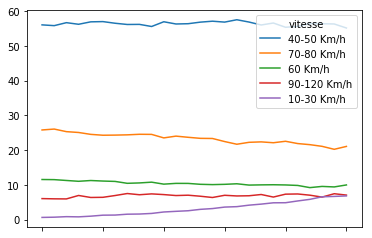

In [68]:
# Circonstance de la vitesse des accidents par année
df_Accident_type_route_normalized = df_Accident_type_route.copy()
for date in [col for col in df_Accident_type_route_normalized.columns if IS_DATE.match(col)]:
    df_Accident_type_route_normalized[date] = df_Accident_type_route_normalized[date]*100/(df_Accident_type_route_normalized[date].sum())
    
req = df_Accident_type_route_normalized[(df_Accident_type_route_normalized.gravite_index!=0)].groupby(['vitesse']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

#### 1.2.2. Cantons

This part describes the main dataset that we plan to use in the scope of a 'canton-scale comparative study'. Since we have an **aggregated** dataset of car accidents in cantons, the possibility of correlations within the dataset are limited. 

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
canton,,,,,,,,,,,,,,,,,,,,,
Zürich,3102.0,2960.0,3135.0,3081.0,2922.0,3102.0,3097.0,3283.0,3367.0,3400.0,...,3115.0,3225.0,3034.0,3012.0,2940.0,2835.0,3044.0,3202.0,3410.0,3352.0
Bern / Berne,3237.0,3176.0,3234.0,3176.0,3019.0,3058.0,3018.0,3107.0,3053.0,3155.0,...,2732.0,2534.0,2561.0,2630.0,2596.0,2462.0,2509.0,2551.0,2465.0,2616.0
Vaud,2725.0,2620.0,2670.0,2602.0,2349.0,2319.0,2422.0,2573.0,2717.0,2538.0,...,2043.0,2032.0,1981.0,1802.0,1758.0,1782.0,1609.0,1400.0,1692.0,1646.0
Aargau,1547.0,1531.0,1691.0,1576.0,1544.0,1484.0,1431.0,1722.0,1686.0,1708.0,...,1408.0,1464.0,1345.0,1358.0,1250.0,1191.0,1215.0,1213.0,1079.0,1155.0
Genève,1122.0,1084.0,1125.0,1039.0,1033.0,1039.0,1167.0,1222.0,1256.0,1359.0,...,1238.0,1142.0,1108.0,918.0,1023.0,1181.0,1300.0,1264.0,1170.0,1127.0


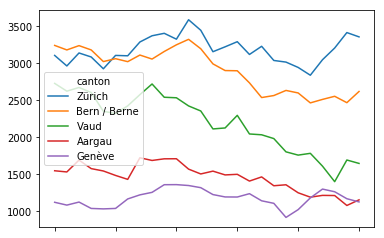

In [73]:
req = df_Accident_cantons.groupby(['canton']).sum().sort_values(['2017'], ascending=False).head(5)[[col for col in df_Accident_cantons.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

In [78]:
# Normalized with the road lentgh
df_Longueur_routes_cantonindex = df_Longueur_routes.copy()
for elem in df_Longueur_routes_cantonindex['canton'].unique():
    try:
        getKeysByValue(dict_cantons, elem)
    except:
        df_Longueur_routes_cantonindex = df_Longueur_routes_cantonindex[df_Longueur_routes_cantonindex.canton!=elem]
df_Longueur_routes_cantonindex['canton'] = [getKeysByValue(dict_cantons, valueToFind) for valueToFind in df_Longueur_routes_cantonindex['canton']]

df_Accident_cantonsindex = df_Accident_cantons.copy()
df_Accident_cantonsindex['canton'] = [getKeysByValue(dict_cantons, valueToFind) for valueToFind in df_Accident_cantonsindex['canton']]

df_Accident_cantonsindex_normalizedkm = df_Accident_cantonsindex.copy().drop(['2017'],axis=1)

for canton in df_Accident_cantonsindex_normalizedkm.canton.unique():
    for date in [d for d in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(d)]:
        df_Accident_cantonsindex_normalizedkm.loc[df_Accident_cantonsindex_normalizedkm.canton==canton,date]=\
        100*df_Accident_cantonsindex_normalizedkm.loc[df_Accident_cantonsindex_normalizedkm.canton==canton,date]/\
        df_Longueur_routes_cantonindex[(df_Longueur_routes_cantonindex.canton == canton) \
                                       & (df_Longueur_routes_cantonindex.annee==int(date))]['Total'].values[0]

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
canton,,,,,,,,,,,,,,,,,,,,,
BS,195.356285,209.866667,230.400000,228.983187,209.500934,218.666667,193.333333,196.266667,175.205734,160.339793,...,141.255007,131.824234,125.699068,101.329787,84.308511,68.085106,86.968085,99.600533,104.127830,109.986684
GE,81.802275,78.556417,83.031958,76.684626,76.241789,76.498307,85.922545,89.972022,92.475335,100.058901,...,87.836843,91.150052,84.081873,81.590574,67.599411,75.331370,86.966127,95.714917,93.132921,86.206897
ZG,53.888011,54.405054,44.408775,57.963260,50.835279,54.787138,57.481588,54.966768,55.864918,57.481588,...,60.573283,61.294393,62.556337,60.180180,56.576577,50.270270,45.765766,49.667087,48.047508,48.407414
ZH,42.728450,40.771350,43.470423,42.439186,40.200314,42.676719,42.607930,45.166882,46.354425,46.725119,...,44.698587,42.359628,43.715773,41.127830,40.813008,39.745843,38.326349,41.151818,43.481803,46.306355
NW,42.247744,33.634126,47.478992,45.416316,47.518923,34.873950,40.756303,53.361345,43.313709,37.426409,...,36.585366,38.782319,36.697248,32.916667,34.166667,32.916667,34.166667,33.361134,42.952460,37.948290


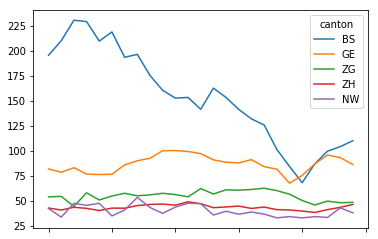

In [79]:
req = df_Accident_cantonsindex_normalizedkm.groupby(['canton']).sum().sort_values(['2016'], ascending=False).head(5)[[col for col in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
canton,,,,,,,,,,,,,,,,,,,,,
GE,81.802275,78.556417,83.031958,76.684626,76.241789,76.498307,85.922545,89.972022,92.475335,100.058901,...,87.836843,91.150052,84.081873,81.590574,67.599411,75.331370,86.966127,95.714917,93.132921,86.206897
ZG,53.888011,54.405054,44.408775,57.963260,50.835279,54.787138,57.481588,54.966768,55.864918,57.481588,...,60.573283,61.294393,62.556337,60.180180,56.576577,50.270270,45.765766,49.667087,48.047508,48.407414
ZH,42.728450,40.771350,43.470423,42.439186,40.200314,42.676719,42.607930,45.166882,46.354425,46.725119,...,44.698587,42.359628,43.715773,41.127830,40.813008,39.745843,38.326349,41.151818,43.481803,46.306355
NW,42.247744,33.634126,47.478992,45.416316,47.518923,34.873950,40.756303,53.361345,43.313709,37.426409,...,36.585366,38.782319,36.697248,32.916667,34.166667,32.916667,34.166667,33.361134,42.952460,37.948290
SZ,46.809947,42.069741,46.681665,52.548667,44.671993,45.781777,45.781777,47.469066,43.771802,44.671993,...,40.283560,41.183752,39.158321,40.269966,36.895388,35.195531,32.625698,30.188259,33.195945,33.084549


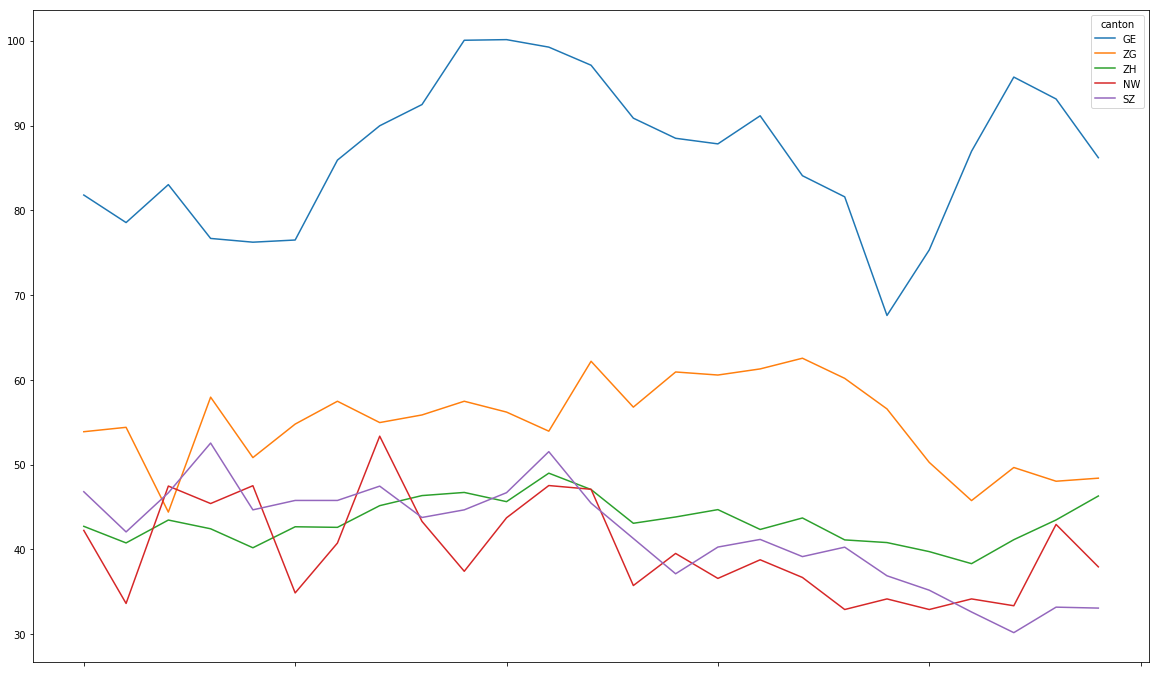

In [89]:
#BS is an outlier
req = df_Accident_cantonsindex_normalizedkm[df_Accident_cantonsindex_normalizedkm.canton!='BS'].groupby(['canton']).sum().sort_values(['2016'], ascending=False).head(5)[[col for col in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
canton,,,,,,,,,,,,,,,,,,,,,
ZH,42.728450,40.771350,43.470423,42.439186,40.200314,42.676719,42.607930,45.166882,46.354425,46.725119,...,44.698587,42.359628,43.715773,41.127830,40.813008,39.745843,38.326349,41.151818,43.481803,46.306355
NW,42.247744,33.634126,47.478992,45.416316,47.518923,34.873950,40.756303,53.361345,43.313709,37.426409,...,36.585366,38.782319,36.697248,32.916667,34.166667,32.916667,34.166667,33.361134,42.952460,37.948290
SZ,46.809947,42.069741,46.681665,52.548667,44.671993,45.781777,45.781777,47.469066,43.771802,44.671993,...,40.283560,41.183752,39.158321,40.269966,36.895388,35.195531,32.625698,30.188259,33.195945,33.084549
SG,45.045045,45.379651,46.306467,43.354387,40.470960,41.638061,43.615200,48.955837,47.993975,49.226875,...,47.853096,43.654857,44.845013,40.801887,42.183288,40.768194,33.018868,32.740501,30.685799,29.506871
UR,36.363636,38.534600,44.233379,49.932157,45.047490,44.776119,43.419267,42.333786,42.876526,43.184885,...,34.278003,31.039136,40.215924,29.380054,28.301887,28.571429,33.153639,25.371120,31.578947,27.530364
LU,34.205231,32.750348,32.719393,33.400402,32.007429,35.350565,32.704782,36.084869,36.766300,40.663257,...,34.226421,35.068747,35.686699,33.827618,34.166667,31.820988,29.845679,31.177651,31.270258,26.392962
SO,30.703335,31.127314,32.569506,32.009935,28.844998,31.768288,30.245974,34.212002,36.496935,35.415248,...,38.524557,33.722231,33.682276,33.799441,31.482221,27.127447,24.770276,23.413777,24.492568,25.251718


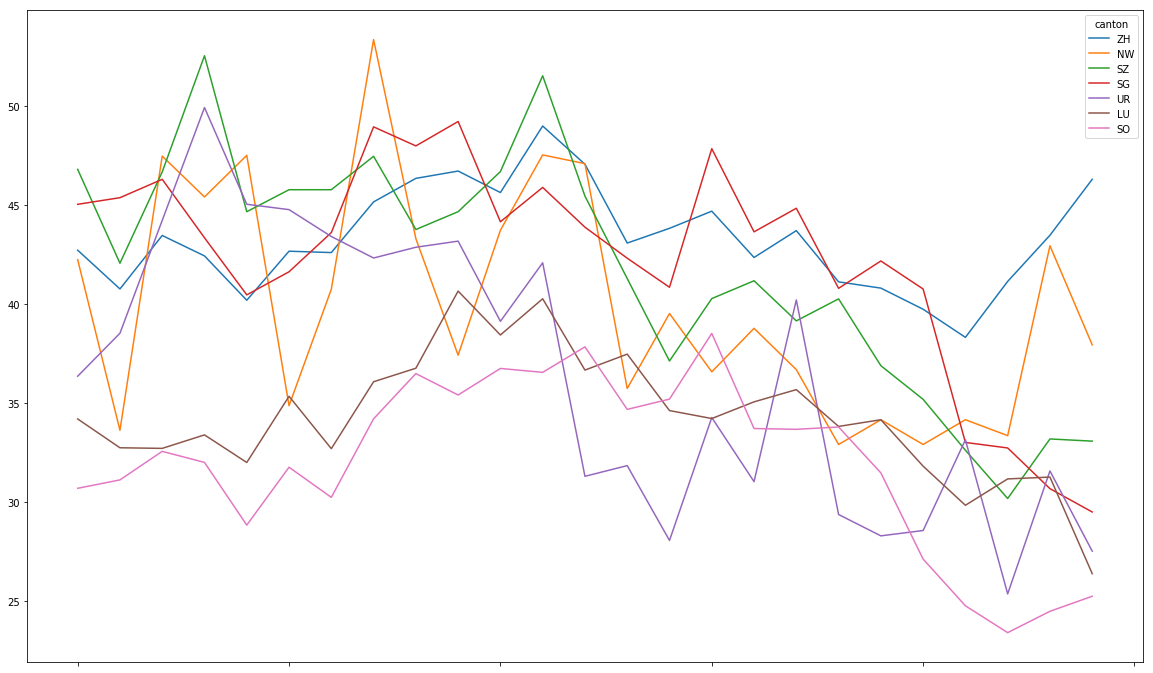

In [90]:
#BS, GE, ZG are an outlier
req = df_Accident_cantonsindex_normalizedkm[(df_Accident_cantonsindex_normalizedkm.canton.isin(['BS','GE','ZG']))==False].groupby(['canton']).sum().sort_values(['2016'], ascending=False).head(7)[[col for col in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

### 1.3. When?

We will then analyze the different circumstances leading to accidents.

In [17]:
# Using df_Accident_circonstances 
describeDf(df_Accident_circonstances)
print('First rows of the dataset:')
display(df_Accident_circonstances.head(2))

______________________________ DESCRIPTION ______________________________



         ATTRIBUTE: mois_index
   [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


         ATTRIBUTE: mois
   ['Janvier' 'Février' 'Mars' 'Avril' 'Mai' 'Juin' 'Juillet' 'Août'
 'Septembre' 'Octobre' 'Novembre' 'Décembre']


         ATTRIBUTE: day_index
   [1. 2. 3. 4. 5. 6. 7.]


         ATTRIBUTE: day
   ['Lundi' 'Mardi' 'Mercredi' 'Jeudi' 'Vendredi' 'Samedi' 'Dimanche']


         ATTRIBUTE: hours_index
   [ 0.  6. 12. 18. 99.]


         ATTRIBUTE: hours
   ['00-05 heures' '06-11 heures' '12-17 heures' '18-24 heures'
 'Heure inconnue']


         ATTRIBUTE: gravite_index
   [315. 316. 317.]


         ATTRIBUTE: gravite
   ['Accidents avec blessés légers' 'Accidents avec blessés graves'
 'Accidents mortels']


         ATTRIBUTE: ruralite_index
   [10. 11. 12.]


         ATTRIBUTE: ruralite
   ['En localité' 'Hors localité' 'Sur autoroute']


         ATTRIBUTE: contexte_index
   ['A' 'C' 'D' 'E' 'G'

,mois_index,mois,day_index,day,hours_index,hours,gravite_index,gravite,ruralite_index,ruralite,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1.0,Janvier,1.0,Lundi,0.0,00-05 heures,315.0,Accidents avec blessés légers,10.0,En localité,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,Janvier,1.0,Lundi,0.0,00-05 heures,315.0,Accidents avec blessés légers,10.0,En localité,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> This dataset might provide some relevant outcomes regarding the decision makers (drivers and/or walkers)

### 1.4. What? (victims)

We will take a look at the different victims of accidents.

In [18]:
describeDf(df_Accident_victimes)
print('First rows of the dataset:')
display(df_Accident_victimes.head(2))

______________________________ DESCRIPTION ______________________________



         ATTRIBUTE: voiture_index
   [210. 211. 214. 220. 221. 222. 223. 224. 227. 228. 229.]


         ATTRIBUTE: voiture
   ['Voiture de tourisme' 'Véhicule de transport de personnes'
 'Véhicule de transport de choses' 'Cycle' 'Cyclomoteur' 'Motocycle léger'
 "Motocycle jusqu'à 125 cm3" 'Motocycle de plus de 125 cm3' 'Piéton'
 'Autre véhicule non motorisé' 'Autre et inconnu']


         ATTRIBUTE: sexe_index
   [1. 2. 9.]


         ATTRIBUTE: sexe
   ['Homme' 'Femme' 'Inconnu']


         ATTRIBUTE: role_index
   [300. 301. 303.]


         ATTRIBUTE: role
   ['Conducteur' 'Piéton' 'Passager']


         ATTRIBUTE: age_index
   [  0.   5.   6.  10.  15.  18.  20.  21.  30.  40.  50.  60.  70. 999.]


         ATTRIBUTE: age
   ["jusqu'à 4 ans" '5 ans' '6-9 ans' '10-14 ans' '15-17 ans' '18-19 ans'
 '20 ans' '21-29 ans' '30-39 ans' '40-49 ans' '50-59 ans' '60-69 ans'
 '70 ans et +' 'Inconnu']


         ATTR

,voiture_index,voiture,sexe_index,sexe,role_index,role,age_index,age,consequence_index,consequence,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,0.0,jusqu'à 4 ans,315.0,Blessé léger,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,0.0,jusqu'à 4 ans,316.0,Blessé grave,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> One more time, since decision makers want to minimize the number of victims, some outcoming correlations between the vehicle type and the accidents for example might be useful in our study. 

## 2. Correlations focused on cantons-granulated data

As shown above, we have a lot of different information about the Swiss cantons Therefore, we decided to focus on them and base our analysis on the correlations between the different variables have and the accidents.
The following datasets have been selected because they are linked to road safety and good operation, such as investment in road sector, expenses of households in alcool and public transport as well as type of cars prefered in each canton. 

We will identify the most important features corrolated to the accidents in Switzerland as a preparation for the part 3 of our project. Below are listed the variables we will consider for this analysis.

For each feature, we plan to measure whether they are correlated to car accidents frequency or not. One approach might be the Pearson coorelation coefficient, however, we could also study if another distribution than normal law is revealed.

### 2.1. Expenses for Roads

Yearly expenses of the different cantons concerning the road sector, found in the dataset below.

In [19]:
# Using df_Frais_routes_cantonales, df_Frais_routes_communales, df_Frais_routes_nationales
display(df_Frais_routes_cantonales.head(2))

,annee,canton,Total,Constructions,Amélio-,Acquisition,Entretien Construction,Entretien Exploitation,Administration,Surveillance Policiere
0,1994,Appenzell Rh.-Ext.,31374.0,0,16298,-46,2796,7706,1705.0,2915
1,1994,Appenzell Rh.-Int.,4206.0,488,931,0,265,1107,887.0,527


### 2.2. Road length

Yearly information about the road network of each canton.

In [20]:
# Using df_Longueur_routes
display(df_Longueur_routes.head(2))

,annee,canton,Total,Routes nationales,Routes cantonales,Routes communales
0,1992,Appenzell Rh.-Ext.,434.0,0.0,231.0,203.0
1,1992,Appenzell Rh.-Int.,139.0,0.0,48.0,91.0


### 2.3. Police

Yearly expenses of the different cantons for the police surveillance on the road sector, found in the dataset below.

In [21]:
# Using df_Frais_routes_cantonales, df_Frais_routes_communales, df_Frais_routes_nationales with "Surveillance Policiere"
display(df_Frais_routes_cantonales.head(2))

,annee,canton,Total,Constructions,Amélio-,Acquisition,Entretien Construction,Entretien Exploitation,Administration,Surveillance Policiere
0,1994,Appenzell Rh.-Ext.,31374.0,0,16298,-46,2796,7706,1705.0,2915
1,1994,Appenzell Rh.-Int.,4206.0,488,931,0,265,1107,887.0,527


### 2.4. Type of cars

Information on the different type of cars in each canton on a yearly basis

In [22]:
# Using df_Voitures
describeDf(df_Voitures)
print('First rows of the dataset:')
display(df_Voitures.head(2))

______________________________ DESCRIPTION ______________________________



         ATTRIBUTE: canton_index
   [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]


         ATTRIBUTE: canton
   ['Zürich' 'Bern / Berne' 'Luzern' 'Uri' 'Schwyz' 'Obwalden' 'Nidwalden'
 'Glarus' 'Zug' 'Fribourg / Freiburg' 'Solothurn' 'Basel-Stadt'
 'Basel-Landschaft' 'Schaffhausen' 'Appenzell Ausserrhoden'
 'Appenzell Innerrhoden' 'St. Gallen' 'Graubünden / Grigioni / Grischun'
 'Aargau' 'Thurgau' 'Ticino' 'Vaud' 'Valais / Wallis' 'Neuchâtel' 'Genève'
 'Jura' 'Confédération']


         ATTRIBUTE: carosserie_index
   [11. 12. 13.]


         ATTRIBUTE: carosserie
   ['Limousine' 'Break' 'Cabriolet']


         ATTRIBUTE: carburant_index
   [ 100.  200.  300. 9900.]


         ATTRIBUTE: carburant
   ['Essence' 'Diesel' 'Electrique' 'Autres']


         ATTRIBUTE: cylindre_index
   [ 1.01399e+05  1.01799e+05  1.01999e+05  1.02499e+05  1.09999e+0

,canton_index,canton,carosserie_index,carosserie,carburant_index,carburant,cylindre_index,cylindre,traction_index,traction,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1.0,Zürich,11.0,Limousine,100.0,Essence,101399.0,jusqu'à 1399 cm3,1.0,Traction avant,...,9465.0,9462.0,9364.0,9276.0,9375.0,9315.0,9448.0,9474.0,9881.0,10412.0
1,1.0,Zürich,11.0,Limousine,100.0,Essence,101399.0,jusqu'à 1399 cm3,1.0,Traction avant,...,86546.0,87274.0,91180.0,96187.0,100565.0,105378.0,109020.0,113222.0,115168.0,116336.0


### 2.5. Expenses of citizens

In [23]:
# Using df_Depense_menages_canton
df_Depense_menages_canton.head(2)

,annee,Canton,Mode,Eaux-de-vie,Vins,Bières,"Boissons alcoolisées dans les restaurants, cafés et bars",Boissons alcoolisées en petite restauration,Boissons alcoolisées dans les cantines,Boissons alcoolisées chez des privés lors d'invitations,...,"Motos, scooters et vélomoteurs",Vélos,Carburants et lubrifiants,"Train, billets et abonnements","Tram, billets et abonnements","Bus, billets et abonnements","Bateau, billets et abonnements",Transport multimodal,Services de téléphonie mobile,Assurance véhicule
0,2006–2008,Zurich,Tot,8.238019489450405,56.251273,8.361510,75.590536,6.067617,0.37909465523331387,( ),...,( ),11.510053967140562,141.489994,34.573547,4.047249522742667,3.842554,3.172501021756669,72.360688,64.300854,101.943344
1,2006–2008,Zurich,Pct,0.0008621494018315626,0.005887,0.000875,0.007911,0.000635,3.967412685360722e-05,( ),...,( ),0.0012045839604442686,0.014808,0.003618,0.0004235646394821113,0.000402,0.00033201789115942093,0.007573,0.006729,0.010669


### 2.6. Impact of the health budget

In [24]:
# Using df_Besoin_sante
df_Besoin_sante.head(2)

,annee,canton,Total,Soins hopitaux,Soins domicile,Administration Prevention,besoin_par_habitant
0,1996,Appenzell Rh.-Ext.,38.845225,37.085203,0.176061,1.583962,751.683415
1,1996,Appenzell Rh.-Int.,4.794571,4.155756,0.363790,0.275025,456.258563


## 3. Predictions

For the well correlated features (low p Value of uncorrelation hypothesis), we will use a machine learning technique and apply a regression to predict the potential number of car accidents following different possible decisions made in investment and road infrastructure by a canton for example.

## 4. Conclusion

Our recommendations to decision makers based on the results of the study!